In [1]:
import pandas as pd
import gensim
import pyLDAvis
import pyLDAvis.gensim
import os
import sklearn as sk 
import json
import numpy as np
import yaml 

import sys
path_to_regroupement = os.path.dirname(os.path.dirname(os.getcwd())) 
sys.path.insert(0,os.path.join(path_to_regroupement, 'analyse/' ))


import analysis, cluster_model_analysis, topic_model_analysis

with open(os.path.join(path_to_regroupement, 'analyse','analyse_config.yaml'), 'r') as stream:
    config_data = yaml.load(stream, Loader=yaml.FullLoader)
    
with open(os.path.join(path_to_regroupement, 'config.yaml'), 'r') as stream:
    globale_config = yaml.load(stream, Loader=yaml.FullLoader)

path_mrv = globale_config['data']['mrv']['path']
data_mrv = pd.read_csv(path_mrv)


SAVE_PATH = config_data['analyse']['path']

#os.path.dirname(os.path.dirname('.'))
sys.path.insert(1,os.path.join(path_to_regroupement, 'training/' ))

config_path = os.path.join(os.path.join(path_to_regroupement, 'training'),'training_config.yaml')


with open(config_path, 'r') as stream:
    config = yaml.load(stream, Loader=yaml.FullLoader)

import train_topic, train_cluster

import hdbscan
from sklearn.preprocessing import StandardScaler

In [2]:
%time
name = 'try_01_10_2020'#config_data['analyse']['name']
# Loading
topicmodel = train_topic.TopicModel(name, config['topic'], 
                                        save_dir=os.path.join(SAVE_PATH, name))
topicmodel.load(name)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


In [70]:
%%time
n = topicmodel.model.num_topics
n_lignes = None #5000
X = topicmodel.doc_topic_mat.iloc[:n_lignes, :n].values
X_trans = StandardScaler().fit_transform(X)

CPU times: user 150 ms, sys: 23.3 ms, total: 174 ms
Wall time: 184 ms


In [56]:
%%time
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, gen_min_span_tree=True)
clusterer.fit(X_trans)

CPU times: user 4.19 s, sys: 707 µs, total: 4.19 s
Wall time: 4.18 s


HDBSCAN(gen_min_span_tree=True, min_cluster_size=15)

In [57]:
print(len(set(clusterer.labels_)))
print(clusterer.labels_)
print(np.sum(clusterer.labels_==-1)/n_lignes)


70
[-1 -1 -1 ... -1 -1 -1]
0.6644


In [52]:
from scipy import stats
stats.describe(clusterer.probabilities_)

DescribeResult(nobs=5000, minmax=(0.0, 1.0), mean=0.28683711739615625, variance=0.18986408738479607, skewness=0.9207964121806164, kurtosis=-1.0841965955054662)

array([[&lt;matplotlib.axes._subplots.AxesSubplot object at 0x7f49938d6be0&gt;]],
      dtype=object)

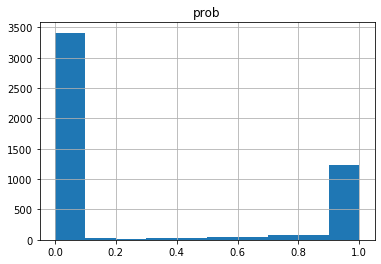

In [58]:
df = pd.DataFrame()
df['label'] = clusterer.labels_
df['prob'] = clusterer.probabilities_
df.hist('prob')

In [42]:
1500/5000

0.3

In [71]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

clf = mixture.GaussianMixture(n_components=100, covariance_type='full')
label = clf.fit_predict(X_trans)

CPU times: user 1h 1min 47s, sys: 33min 32s, total: 1h 35min 20s
Wall time: 33min 41s


In [77]:
from sklearn import metrics

silhouette_score = metrics.silhouette_score(X_trans, label, metric='euclidean')
calinski_harabasz_score = metrics.calinski_harabasz_score(X_trans, label)
davies_bouldin_score = metrics.davies_bouldin_score(X_trans, label)

In [78]:
silhouette_score

-0.07998465

In [81]:
calinski_harabasz_score

163.88941683140723

In [80]:
davies_bouldin_score

4.526865328655792

CPU times: user 2min 57s, sys: 1min 13s, total: 4min 10s
Wall time: 1min 17s


Text(0.5, 0, &#39;n_components&#39;)

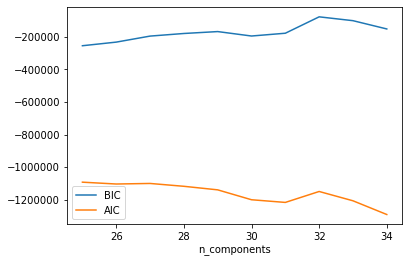

In [69]:
%%time
from sklearn.mixture import GaussianMixture as GMM
n_components = np.arange(25, 35)
models = [GMM(n, covariance_type='full', random_state=0).fit(X_trans)
          for n in n_components]

plt.plot(n_components, [m.bic(X_trans) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_trans) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [63]:
print(len(set(label)))
print(label)


2
[1 1 1 ... 1 1 1]


In [ ]:
clf.